## 0 Imports

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import gpflow
from gpflow.kernels import SquaredExponential, SharedIndependent, SeparateIndependent
from gpflow.inducing_variables import SharedIndependentInducingVariables, InducingPoints
from gpflow.utilities import print_summary
from gpflow.ci_utils import ci_niter

from GWP.BANNER.src.models.WishartProcess import WishartProcess
from GWP.BANNER.util.training_util import run_adam
from GWP.BANNER.src.kernels.PartlySharedIndependentMOK import PartlySharedIndependentMultiOutput
from GWP.BANNER.src.likelihoods.WishartProcessLikelihood import WishartLikelihood


## Import depression data

In [2]:
def transform_days(x):
    if x > 255:
        return x - 255
    else:
        return x + 141

In [3]:
data = pd.read_csv(r"C:\Users\Zizi\Desktop\master\Thesis\GaussianProcessesMDD\ESMdata\ESMdata.csv") 
#day no is the day number of the year in which the experiment took place, so 
# it starts at 226 and ends at 98.
# this is shifted to start at 1 and end at 239 such that the first day is day 1 and the last day is day 239
data["dayno"] =data["dayno"].apply(lambda x: x-225 if x in range(225,367) else x+141)
scl_indeces = [2,3,4] + [i for i in range(data.columns.get_loc("SCL.90.R.29"),(data.columns.get_loc("dep")+1))]
scl_data = data.iloc[:,scl_indeces]
scl_data = scl_data.dropna()
scl_data = scl_data.drop_duplicates("dayno")
print(scl_data.columns)

Index(['phase', 'concentrat', 'dayno', 'SCL.90.R.29', 'SCL.90.R.26',
       'SCL.90.R.15', 'SCL.90.R.30', 'SCL.90.R.31', 'SCL.90.R.32',
       'SCL.90.R.54', 'SCL.90.R.71', 'SCL.90.R.79', 'dep'],
      dtype='object')


In [4]:
D  = 9
line = pd.DataFrame({'phase':1, 'concentrat':150, 'dayno':22, 'SCL.90.R.29':np.nan, 'SCL.90.R.26':np.nan,
       'SCL.90.R.15':np.nan, 'SCL.90.R.30':np.nan, 'SCL.90.R.31':np.nan, 'SCL.90.R.32':np.nan,
       'SCL.90.R.54':np.nan, 'SCL.90.R.71':np.nan, 'SCL.90.R.79':np.nan, 'dep':np.nan}, index=[4])
#df2 = pd.concat([scl_data.iloc[:3], line, scl_data.iloc[3:]]).reset_index(drop=True)

df3 = pd.concat([scl_data, scl_data, scl_data, scl_data.iloc[:16]]).reset_index(drop=True)
print(df3)
scl_time = scl_data["dayno"].to_numpy()
# scl_time = np.insert(scl_time,3, 22)
scl_time = np.concatenate((np.tile(scl_time, 3),scl_time[:16]))
scl_X =np.tile(scl_time, (D,1)).T.astype('float64')
scl_Y = df3.iloc[:,3:12].to_numpy()
T = np.max(scl_time)
N = scl_X.shape[0]
print(scl_X.shape)

# for ind, val in enumerate(scl_time):
#     if ind*7 + 1 not in scl_time:
        
#missing weeks: 3,4,7,19,28,29,33

    phase  concentrat  dayno  SCL.90.R.29  SCL.90.R.26  SCL.90.R.15  \
0       1         150      1          1.0          1.0          1.0   
1       1         150      8          1.0          1.0          1.0   
2       1         150     15          1.0          1.0          1.0   
3       2         150     36          1.0          1.0          1.0   
4       3         150     43          1.0          1.0          1.0   
..    ...         ...    ...          ...          ...          ...   
95      4           0     99          1.0          1.0          1.0   
96      4           0    106          1.0          1.0          1.0   
97      4           0    113          1.0          1.0          1.0   
98      4           0    120          2.0          2.0          1.0   
99      4           0    127          1.0          1.0          1.0   

    SCL.90.R.30  SCL.90.R.31  SCL.90.R.32  SCL.90.R.54  SCL.90.R.71  \
0           1.0          1.0          1.0          1.0          1.0   
1    

Some weeks are missing, namely 3,4,7,19,28,29,33 when counting from 0. 
This is not a problem for banner or for mogp, however MGARCH requires equal distances between datapoints.
Furthermore there are too few datapoints for MGARCH, since it requires 100 datapoints.
Hence, the dataset needs to be sligtly adjusted.

In [8]:
# print(scl_X)
# line = pd.DataFrame({"onset": 30.0, "length": 1.3}, index=[3])
# df2 = pd.concat([df.iloc[:2], line, df.iloc[2:]]).reset_index(drop=True)

[[  1.   1.   1.   1.   1.   1.   1.   1.   1.]
 [  8.   8.   8.   8.   8.   8.   8.   8.   8.]
 [ 15.  15.  15.  15.  15.  15.  15.  15.  15.]
 [ 36.  36.  36.  36.  36.  36.  36.  36.  36.]
 [ 43.  43.  43.  43.  43.  43.  43.  43.  43.]
 [ 57.  57.  57.  57.  57.  57.  57.  57.  57.]
 [ 64.  64.  64.  64.  64.  64.  64.  64.  64.]
 [ 71.  71.  71.  71.  71.  71.  71.  71.  71.]
 [ 78.  78.  78.  78.  78.  78.  78.  78.  78.]
 [ 85.  85.  85.  85.  85.  85.  85.  85.  85.]
 [ 92.  92.  92.  92.  92.  92.  92.  92.  92.]
 [ 99.  99.  99.  99.  99.  99.  99.  99.  99.]
 [106. 106. 106. 106. 106. 106. 106. 106. 106.]
 [113. 113. 113. 113. 113. 113. 113. 113. 113.]
 [120. 120. 120. 120. 120. 120. 120. 120. 120.]
 [127. 127. 127. 127. 127. 127. 127. 127. 127.]
 [141. 141. 141. 141. 141. 141. 141. 141. 141.]
 [148. 148. 148. 148. 148. 148. 148. 148. 148.]
 [155. 155. 155. 155. 155. 155. 155. 155. 155.]
 [162. 162. 162. 162. 162. 162. 162. 162. 162.]
 [169. 169. 169. 169. 169. 169. 169. 169

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

## 2 Wishart inference 


The functions below are used for running the **inference**

In [16]:
def run_wishart_process_inference(data, T, iterations=10000, num_inducing=None, learning_rate=0.01, batch_size=25):
    """

    :param data: Tuple (X, Y) of input and responses.
    :param T: Last timepoint (assume we start at t=0).
    :param iterations: Number of variational inference optimization iterations.
    :param num_inducing: Number of inducing points (inducing points are in the same space as X).
    :param learning_rate: Optimization parameter.
    :param batch_size: Data is split into batches of size batch_size, for stochastic optimization (otherwise we'll run
    out of memory).
    :return: Returns a dictionary with the posterior Wishart process (with trained hyperparameters and variational
    parameters), and a list with the ELBO (loss) per iteration.
    """
    X, Y = data
    N, D = Y.shape
    if num_inducing is None:
        num_inducing = int(0.4 * N)

    model_inverse = False
    additive_noise = True

    nu = D + 1  # Degrees of freedom
    mnu = "shared" #number of mu gaussian processes
    R = 10  # samples for variational expectation
    if mnu is not None:
        mnu_val = 0
    else:
        mnu_val = 1
    latent_dim = int((nu+mnu_val) * D)

    if num_inducing == N:
        Z_init = tf.identity(X)  # X.copy()
    else:
        Z_init = np.array([np.linspace(0, T, num_inducing) for _ in range(D)]).T   # initial inducing variable locations
    Z = tf.identity(Z_init)
    iv = SharedIndependentInducingVariables(InducingPoints(Z))  # multi output inducing variables

    kernel_type = 'partially_shared'  # ['shared', 'separate', 'partially_shared']   # shares the same kernel parameters across input dimension
    kernel = SquaredExponential(lengthscales=5.)

    if kernel_type == 'shared':
        kernel = SharedIndependent(kernel, output_dim=latent_dim)
    elif kernel_type == 'separate':
        kernel = SeparateIndependent([SquaredExponential(lengthscales=1. - (i + 6) * 0.01) for i in range(latent_dim)])
    elif kernel_type == 'partially_shared':
        kernel = PartlySharedIndependentMultiOutput([SquaredExponential(lengthscales=0.5 + i * 0.5) for i in range(D)], nu=(nu+mnu_val))
    else:
        raise NotImplementedError

    # likelihood
    likelihood = WishartLikelihood(D, nu , mnu= mnu, R=R, additive_noise=additive_noise, model_inverse=model_inverse)
    # create GWP model

    wishart_process = WishartProcess(kernel, likelihood, D=D, nu=nu,  inducing_variable=iv,  mnu= mnu)

    # If num_inducing==N, we do not actually have inducing points.
    if num_inducing == N:
        gpflow.set_trainable(wishart_process.inducing_variable, False)

    elbo = run_adam(wishart_process, data, ci_niter(iterations), learning_rate, batch_size, natgrads=False, pb=True)
    return {'wishart process': wishart_process, 'ELBO': elbo}

### 2.1 train the model

In [17]:
num_iter = 4000
                        
                                 
gwp_results = run_wishart_process_inference(data=(scl_X, scl_Y), T=T,
                                            iterations=num_iter,
                                            num_inducing=int(0.4*N),
                                            batch_size=100)
posterior_wishart_process = gwp_results['wishart process']
elbo = gwp_results['ELBO']

#print_summary(posterior_wishart_process)



  0%|                                                 | 0/4000 [00:00<?, ?it/s]

100%|██████████████████████████████████████| 4000/4000 [09:57<00:00,  6.70it/s]


In [18]:
#printing the u used in the wishart process
num_samples = 500
T_test = T*2
N_test = N*2
testpoints = np.tile(np.linspace(0, T_test, N_test), (D, 1)).T

sigma_samples, mu_samples = posterior_wishart_process.predict_mc(testpoints, num_samples )

sigma_mean, mu = posterior_wishart_process.predict_map(testpoints)

y_samples = np.zeros_like(mu_samples)

for s in range(num_samples):
    for t in range(int(N_test)):
        y_samples[s,t] = np.random.multivariate_normal(mu_samples[s,t], sigma_samples[s,t])


In [19]:
mu_y = np.mean(y_samples,axis = 0)
var_y = np.var(y_samples, axis = 0 )


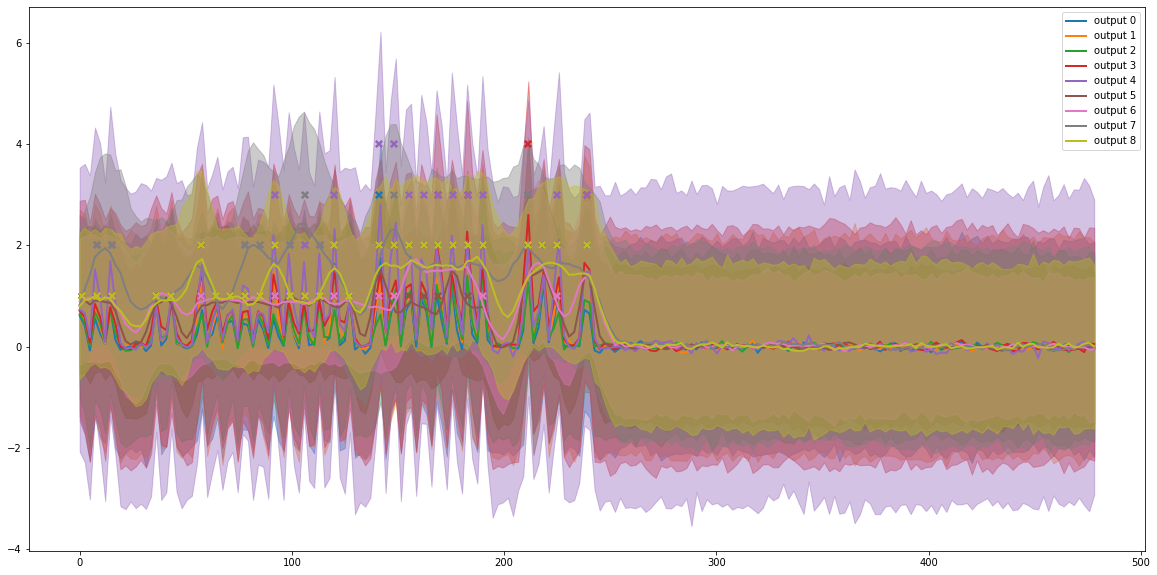

In [20]:
def plot_gp(x, mu, var, color, label):
    plt.plot(x, mu, color=color, lw=2, label=label)
    plt.fill_between(
        x[:, 0],
        (mu - 2 * np.sqrt(var))[:, 0],
        (mu + 2 * np.sqrt(var))[:, 0],
        color=color,
        alpha=0.4,
    )


def plot(Xtest, mus, vs, X, Y):
    plt.figure(figsize=(20, 10))
    for i, (mu, var) in enumerate(zip(mus, vs)):
        (line,) = plt.plot(X[:,i], Y[:,i], "x", mew=2)
        label = "output " + str(i)
        mu = mu[:,None]
        var = var[:,None]
        plot_gp( Xtest, mu, var ,line.get_color(), label)
    plt.legend()
    plt.show

plot(testpoints[:,0][:,None], mu_y.T, var_y.T, scl_X , scl_Y)

In [21]:
def plot_loss(num_iter, loss):
    x = np.linspace(1, num_iter, len(loss))
    fig = plt.figure()
    plt.plot(x, loss, label='ELBO')
    plt.xlim([x[0], x[-1]])
    plt.xlabel('Iteration')
    plt.ylabel('ELBO')
    plt.title('Training convergence')
    plt.tight_layout()


#
def plot_wishart_process_sample(X, Sigma):
    N, D, _ = Sigma.shape
    c1 = '#363537'
    c2 = '#EF2D56'
    fig, axes = plt.subplots(nrows=D, ncols=D, sharex=True, sharey=True, figsize=(10, 10))
    x = X[:, 0]

    for i in range(D):
        for j in range(D):
            ax = axes[i, j]
            if j < i:
                ax.axis('off')
            else:
                ax.plot(x, Sigma[:, i, j], color=c1, lw=2, label='Ground truth')
                ax.set_xlim([x[0], x[-1]])
                ax.set_title('$\sigma_{{{:d},{:d}}}(t)$'.format(i + 1, j + 1), fontsize=20)
    return fig, axes


#
def plot_wishart_predictions(samples, X, axes=None, plot_individuals=0):
    posterior_expectation = tf.reduce_mean(samples, axis=0).numpy()
    posterior_variance = tf.math.reduce_variance(samples, axis=0).numpy()

    c1 = '#363537'
    c2 = '#EF2D56'

    _, D = X.shape
    x = X[:, 0]
    if axes is None:
        fig, axes = plt.subplots(nrows=D, ncols=D, sharex=True, sharey=True, figsize=(10, 10))

    for i in range(D):
        for j in range(D):
            ax = axes[i, j]
            if j < i:
                ax.axis('off')
            else:
                mean = posterior_expectation[:, i, j]
                intv = 1.96*np.sqrt(posterior_variance[:, i, j])
                ax.plot(x, mean, lw=2, c=c2, label='BANNER posterior mean')
                ax.fill_between(x, mean - intv, mean + intv, color=c2, alpha=0.2, label='BANNER 95\% HDI')
                if plot_individuals > 0:
                    ixs = np.random.randint(0, samples.shape[0], size=plot_individuals)
                    for ix in ixs:
                        ax.plot(x, samples[ix, :, i, j].numpy(), c=c2, alpha=0.4, lw=0.5)
                ax.set_xlim([x[0], x[-1]])


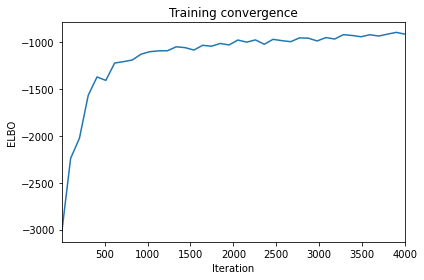

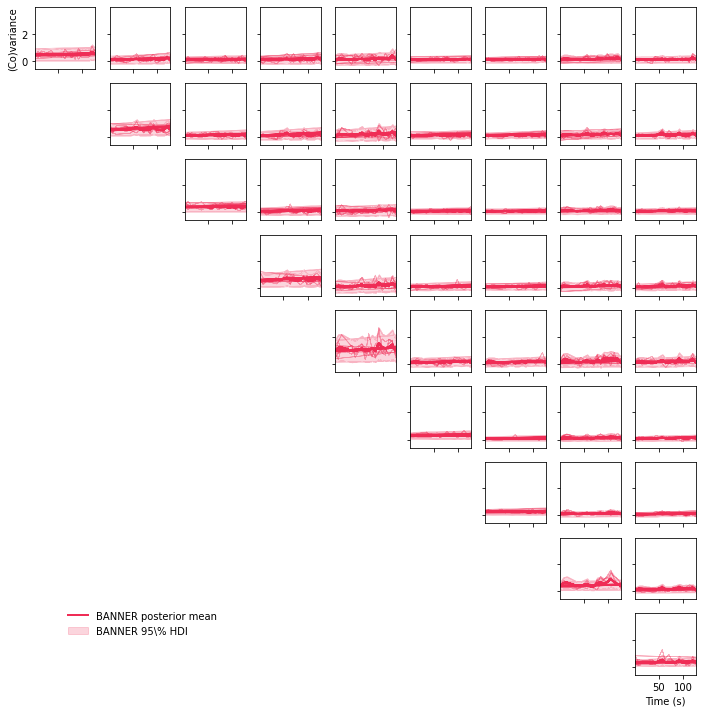

In [22]:
elbo = gwp_results['ELBO']

plot_loss(num_iter, elbo)

num_samples = 5000

# fig, axes = plot_wishart_process_sample(scl_X, Sigma_true)
fig, axes = plt.subplots(nrows=D, ncols=D, sharex=True, sharey=True, figsize=(10, 10))
samples , _= posterior_wishart_process.predict_mc(scl_X, num_samples) #(num_samples, N, D, D)
plot_wishart_predictions(samples=samples, X=scl_X, axes=axes, plot_individuals=5)
# plot_sliding_window(sliding_window_inv_wishart_mean, sliding_window_inv_wishart_var, axes=axes)

axes[-1, -1].set_xlabel('Time (s)')
axes[0, 0].set_ylabel('(Co)variance')
handles, labels = axes[-1, -1].get_legend_handles_labels()
plt.figlegend(handles, labels,
              ncol=1, loc='lower left', bbox_to_anchor=(0.1, 0.10), frameon=False)
plt.tight_layout()
plt.show()

# for i in range(D):
#     print('Variable {:d}'.format(i))
#     print('True lengthscale: {:0.3f}'.format(true_lengthscale[i]))
#     print('Estimated lengthscale: {:0.3f}'.format(posterior_wishart_process.kernel.kernels[i].kernel.lengthscales.numpy().item()))
#     print('True variance: {:0.3f}'.format(true_variance[i]))
#     print('Estimated variance: {:0.3f}'.format(posterior_wishart_process.kernel.kernels[i].kernel.variance.numpy().item()))

# 3 Multi-output GP

In [23]:
import gpflow
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from gpflow.ci_utils import ci_niter

plt.rcParams["figure.figsize"] = (12, 6)
np.random.seed(123)

In [24]:
X = []
Y = []
for dim in range(D):
    X.append(scl_X[:,dim][:,None])
    Y.append(scl_Y[:,dim][:,None])



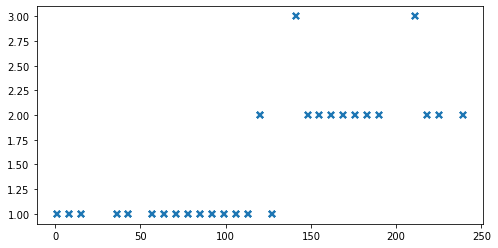

In [25]:
plt.figure(figsize=(8, 4))
# for dim, _ in enumerate(X):
#     plt.plot(X[dim],Y[dim],"x", mew=2)
plt.plot(X[0],Y[0],"x", mew=2)

In [26]:
# Augment the input with ones or zeros to indicate the required output dimension
X_augmented = np.vstack((np.hstack((X[0], np.zeros_like(X[0]))), np.hstack((X[1], np.ones_like(X[1])))))
for indx in range(2,len(X)):
    X_augmented = np.vstack((X_augmented, np.hstack((X[indx],np.ones_like(X[indx])*indx))))

# Augment the Y data with ones or zeros that specify a likelihood from the list of likelihoods
Y_augmented = np.vstack((np.hstack((Y[0], np.zeros_like(Y[0]))), np.hstack((Y[1], np.ones_like(Y[1])))))
for indy in range(2,len(Y)):
    Y_augmented = np.vstack((Y_augmented, np.hstack((Y[indy],np.ones_like(Y[indy])*indy))))

In [27]:
output_dim = 9  # Number of outputs
rank = 9 # Rank of W:  it is the number of degrees of correlation between the outputs.

# Base kernel
k = gpflow.kernels.Matern32(active_dims=[0])

# Coregion kernel
coreg = gpflow.kernels.Coregion(output_dim=output_dim, rank=rank, active_dims=[1])

kern = k * coreg #changep

In [ ]:
# This likelihood switches between Gaussian noise with different variances for each f_i:
lik = gpflow.likelihoods.SwitchedLikelihood(
    [gpflow.likelihoods.Gaussian(),gpflow.likelihoods.Gaussian(),gpflow.likelihoods.Gaussian(),gpflow.likelihoods.Gaussian(),gpflow.likelihoods.Gaussian(),gpflow.likelihoods.Gaussian(),gpflow.likelihoods.Gaussian(),gpflow.likelihoods.Gaussian(),gpflow.likelihoods.Gaussian()]
)

# now build the GP model as normal
m = gpflow.models.VGP((X_augmented, Y_augmented), kernel=kern, likelihood=lik)

# fit the covariance function parameters
maxiter = ci_niter(5000)
gpflow.optimizers.Scipy().minimize(
    m.training_loss, m.trainable_variables, options=dict(maxiter=maxiter), method="L-BFGS-B",
)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [ ]:
def plot_gp(x, mu, var, color, label):
    plt.plot(x, mu, color=color, lw=2, label=label)
    plt.fill_between(
        x[:, 0],
        (mu - 2 * np.sqrt(var))[:, 0],
        (mu + 2 * np.sqrt(var))[:, 0],
        color=color,
        alpha=0.4,
    )


def plot(Xtest, mus, vs, X, Y):
    plt.figure(figsize=(20, 10))
    for i, (mu, var) in enumerate(zip(mus, vs)):
        (line,) = plt.plot(X[:,i], Y[:,i], "x", mew=2)
        label = "output " + str(i)
        plot_gp( Xtest, mu, var ,line.get_color(), label)
    plt.legend()

Xtest = np.linspace(0,T,N)[:,None]
mus = []
vs=  []
for out in range(output_dim):
    mu, var = m.predict_f(np.hstack((Xtest, np.ones_like(Xtest)*out)))
    mus.append(mu)
    vs.append(var)

plot(Xtest, mus, vs, scl_X , scl_Y)


In [ ]:
print(Y_augmented)
mu, var = m.predict_f(X_augmented)
print(mu, var.shape)

# 4 MGARCH

In [ ]:
#source: https://quant.stackexchange.com/questions/20687/multivariate-garch-in-python
#http://www.unstarched.net/r-examples/rmgarch/


Train the mgarch model and compute the covariance

In [ ]:
from rpy2.robjects import pandas2ri
import rpy2.robjects as ro 

import numpy as np
import pandas as pd
from rpy2.robjects.conversion import localconverter

df = pd.DataFrame(scl_Y, columns = ['A','B','C','D','E','F','G','H','I'])
print(df)
pd_rets = pd.DataFrame(df)

# compute DCC-Garch in R using rmgarch package
pandas2ri.activate()
with localconverter(ro.default_converter + pandas2ri.converter):
    r_rets = ro.conversion.py2rpy(pd_rets)
 # convert the daily returns from pandas dataframe in Python to dataframe in R
r_dccgarch_code = """
                library('rmgarch')
                function(r_rets, n_days){
                        univariate_spec <- ugarchspec(mean.model = list(armaOrder = c(0,0)),
                                                    variance.model = list(garchOrder = c(1,1),
                                                                        variance.targeting = FALSE, 
                                                                        model = "sGARCH"),
                                                    distribution.model = "norm")
                        n <- dim(r_rets)[2]
                        dcc_spec <- dccspec(uspec = multispec(replicate(n, univariate_spec)),
                                            dccOrder = c(1,1),
                                            distribution = "mvnorm")
                        dcc_fit <- dccfit(dcc_spec, data=r_rets)
                        show(dcc_fit)
                        forecasts <- dccforecast(dcc_fit, n.ahead = n_days)
                        covariances = rcov(dcc_fit)
                        list(dcc_fit, forecasts@mforecast$H, covariances)
                }
                """
r_dccgarch = ro.r(r_dccgarch_code)
n_days= 4
r_res = r_dccgarch(r_rets,n_days)

pandas2ri.deactivate()
# end of R

r_dccgarch_model = r_res[0] # model parameters

r_forecast_cov = r_res[1] # forecasted covariance matrices for n_days

r_cov = r_res[2] # the covarince matrices for known points

# access and transform the covariance matrices in R format
n_cols = pd_rets.shape[1] # get the number of stocks in pd_rets
n_elements = n_cols*n_cols # the number of elements in each covariance matrix
n_matrix = int(len(r_forecast_cov[0])/(n_elements))
print(n_matrix) # this should be equal to n_days

# sum the daily forecasted covariance matrices 
cov_matrix = 0
for i in range(n_matrix):
    i_matrix = np.array([v for v in r_forecast_cov[0][i*n_elements:(i+1)*n_elements]])
    i_matrix = i_matrix.reshape(n_cols,n_cols)    
    cov_matrix += i_matrix


transform the r object ino a numpy array

In [ ]:
#transform the r object ino a numpy array
mgarch_sigma = np.zeros((N,D,D))
for i in range(N*D*D):
    mgarch_sigma[i//(D*D),(i%(D*D))//D, (i%(D*D))%D]= r_cov[i]


Compute mean for mgarch


In [ ]:
mgarch_y_samples = np.zeros_like(y_samples)
for i in range(mgarch_y_samples.shape[0]):
    for t in range(int(N)):
        mgarch_y_samples[i,t] = np.random.multivariate_normal([0,0,0,0,0,0,0,0,0], mgarch_sigma[t])

# 5 results

Below are functions used for **plotting**

In [ ]:
B = coreg.output_covariance().numpy()

print("B =", B)
_ = plt.imshow(B)
plt.show()

avg_sigma = tf.reduce_mean(Sigma_true, axis = 0)
_ = plt.imshow(avg_sigma)
plt.show()

avg_mgarch = tf.reduce_mean(mgarch_sigma, axis = 0)
_ = plt.imshow(avg_mgarch)
plt.show()
avg_gwp = tf.reduce_mean(samples, axis=0).numpy()
avg_gwp = tf.reduce_mean(avg_gwp, axis =0)
_ = plt.imshow(avg_gwp)
plt.show()


Mean squared error



In [ ]:
def MSE(Ytest, predictions ):
    mse = np.zeros_like(predictions)
    for sample in range(predictions.shape[0]):
        for iy,y in enumerate(Ytest):
            mse[sample,iy] = (y - predictions[sample,iy])**2
    return np.mean(mse, axis = 1)

In [ ]:
def correlation(Ytest, predictions):
    corr = np.corrcoef(Ytest, predictions)
    corr = np.mean(corr, axis = 0)
    return corr
        

In [ ]:
Y_test = sample_observations(Sigma_true, np.array([-3., 0, 3.]))
Y_test.shape
mse = MSE(Y_test, y_samples)
print(mse)
mean_mse = np.mean(mse, axis = 0)
var_mse = np.var(mse, axis =0)

likelihood

In [ ]:
AF = np.ones((10,3,2))
affa = np.matmul(AF, np.transpose(AF, [0, 2, 1]))
affab = np.sum(AF, axis = -1)
print(affa)
mu = 1